Let's implement this timestep thing properly. Each timestep is a different lag, not a different player.

Jason Brownlee has a more suitable tutorial for me to base this work on. It's here: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

I aim to predict points for 2016-2017. I don't have the analysis to dictate which stats I should include for the prediction, so I'll have to start with that.

Once I have the stat analysis in hand, I'll only focus on the top players.


In [1]:
from math import sqrt
import numpy
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Masking

#import csv
#import matplotlib.pyplot as plt
#import pandas as pd
#import math

import seaborn as sns

%matplotlib inline
 

Using TensorFlow backend.


JB uses a different dataset, but let's try his data format tool for NHL data.

Let's keep in mind that this function takes in an array and outputs a dataframe.


# Stat analysis forwards



In [32]:
# load the data
statspd=read_csv('s_skater_summary.csv')#,header=None)

# we'll keep only the players who have more than 40 points in a season:
keep = statspd[statspd.points > 40].playerId.unique()

# isolate only stats for our players of interest
SKATERstats = statspd[statspd['playerId'].isin(keep)]

# we'll only look at forwards:
keep = SKATERstats[SKATERstats.playerPositionCode.isin(['R','L','C'])].playerId.unique()

# isolate only stats for our players of interest
SKATERstats = statspd[statspd['playerId'].isin(keep)]

# prepare to remove some data for now
print(SKATERstats.columns)

Index(['assists', 'faceoffWinPctg', 'gameWinningGoals', 'gamesPlayed', 'goals',
       'otGoals', 'penaltyMinutes', 'playerFirstName', 'playerId',
       'playerLastName', 'playerName', 'playerPositionCode',
       'playerTeamsPlayedFor', 'plusMinus', 'points', 'pointsPerGame',
       'ppGoals', 'ppPoints', 'seasonId', 'shGoals', 'shPoints',
       'shiftsPerGame', 'shootingPctg', 'shots', 'timeOnIcePerGame'],
      dtype='object')


In [35]:
SKATERstats.drop(['faceoffWinPctg', 'gameWinningGoals',
       'otGoals', 'penaltyMinutes', 'playerFirstName', 'playerId',
       'playerLastName', 'playerName', 'playerPositionCode',
       'playerTeamsPlayedFor', 'pointsPerGame', 'seasonId', 'shGoals', 'shPoints'], axis=1, inplace=True)

/Users/Galloway/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [36]:
SKATERstats[:25]

,assists,gamesPlayed,goals,plusMinus,points,ppGoals,ppPoints,shiftsPerGame,shootingPctg,shots,timeOnIcePerGame
1,36,82,39,-1,75,9,22,25.1707,0.1363,286,1108.1951
2,19,73,26,7,45,5,11,22.6986,0.1556,167,1011.4520
4,18,81,34,9,52,9,14,20.3580,0.1780,191,935.2962
9,15,81,27,13,42,3,6,21.1728,0.1516,178,1004.2592
11,8,49,6,4,14,0,2,17.5510,0.1304,46,747.5102
12,21,74,6,-3,27,3,5,18.8108,0.0416,144,902.8783
14,23,77,18,-34,41,3,9,23.3376,0.1125,160,1098.2467
15,18,70,23,-10,41,5,13,22.8428,0.1138,202,1061.6000
22,23,68,33,28,56,7,13,21.9117,0.2307,143,1071.2941
25,32,81,35,15,67,8,13,24.7530,0.1305,268,1150.5925


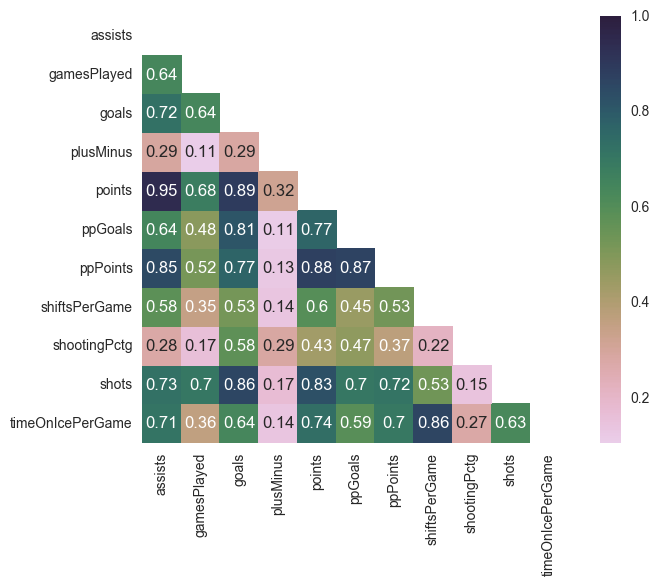

In [40]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = numpy.zeros_like(SKATERstats.corr(method = 'spearman') , dtype=numpy.bool)
mask[numpy.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.cubehelix_palette(n_colors=12, start=-2.25, rot=-1.3, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(SKATERstats.corr(method = 'spearman') ,annot=True,  mask=mask, cmap=cmap, vmax=1, square=True)

pyplot.show()

Okay, points is most correlated to (from highest): points, assists, goals, ppPoints, shots, ppGoals, timeOnIcePerGame, gamesPlayed, shiftsPerGame. ppPoints and ppAssists are intuitively too related to points and goals, so I won't include all four of these categories. Similarly, shiftsPerGame is too related to timeOnIcePerGame, so I'll discard. I think this approach also applies to goals and assists... too related to points to include them all. That leaves the categories as: points, ppPoints (I'm leaving this in as a proxy for ppTOI), shots, gamesPlayed, and timeOnIcePerGame. 

# Model and Predict

I'll train the model on data up to 2015-2016, then use the model to predict the 2016-2017 performance based on previous seasons.

In [55]:
# convert series to supervised learning
def series_to_supervised_modified(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    
    cols.append(df.shift(n_in))
    names += [('var%d(t-%d)' % (j+1, n_in)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [56]:
def sortforML_scale_supervised(df ,lags, scaler):
    # Input a dataframe, get back a numpy array.
    # Lags is an integer denoting the lumber of lags to include for the model.
    # Scaler is a... well, scaler
    
    # This algorithm assumes the dataframe is already sorted by year (latest first).
    # Also, make sure the dataframe has the stat you desire to predict as the last column.
    
    # To match JB's example, the data should exist as (sample,timestep,features).
    # Wait a second... he uses all the time sampels as samples, not timesteps. I'll just do what he does!
    
    
    # initiate output array
    templag = numpy.zeros((0,len(df.columns)+1))
    
    for i in range(lags):
        
        for player in df.playerId.unique():
            
            # Grab array of a single player
            popped = df.loc[df['playerId'] == player].values
            
            # apply scaler
            popscaled = scaler.transform(popped)
            
            # transform to supervised (takes array and returns df - this enables the next step...)
            poptrans = series_to_supervised_modified(popscaled, i+1, 1)
            # remove all new columns except the new un-lagged one that we're trying to predict
            poptrans.drop(poptrans.columns[[7,8,9,10,11,12]], axis=1, inplace=True) # need to change these values if the number of features changes.
            # add players results to this templag
            templag = numpy.append(templag,poptrans.values, axis=0)
        
        if i ==0:
            # intitialize the output array
            out = numpy.array([templag])
        else:
            # create a template of the correct dimensions for the output array
            templ = numpy.zeros((out.shape[1], out.shape[2])) - 1
            # place templag into this template
            templ[:len(templag),:] = templag
            # append this teamplate into the output array
            out = numpy.append(out,[templ],axis=0)
            
        # initialize the templag for the next lag
        templag = numpy.zeros((0,len(df.columns)+1))
        
    # Transpose out to match the expected shape of the model: samples/timesteps/features
    out = numpy.transpose(out,(1,0,2))
        
    return out

In [107]:
def sortforML_scale_supervised_prediction(df ,lags, scaler):
    #Specifically for testing. Builds a an array to predict from.
    
    # Input a dataframe, get back a numpy array.
    # Lags is an integer denoting the lumber of lags to include for the model.
    # Scaler is a... well, scaler
    
    # This algorithm assumes the dataframe is already sorted by year (latest first).
    # Also, make sure the dataframe has the stat you desire to predict as the last column.
    
    # To match JB's example, the data should exist as (sample,timestep,features).
    # Wait a second... he uses all the time sampels as samples, not timesteps. I'll just do what he does!
    
    
    # initiate output array
    templag = numpy.zeros((0,len(df.columns)+1))
    latestseason = max(df.seasonId)
    
    #extract years for reference
    yeartempl = numpy.zeros((len(df.seasonId.unique()),len(df.columns)))
    for i in range(len(yeartempl)):
        yeartempl[i,df.columns.get_loc('seasonId')] = latestseason - i*10001
    yearscale = scaler.transform(yeartempl)
    yearscale = yearscale[:,df.columns.get_loc('seasonId')]
            
    
    for i in range(lags):
        
        for player in df.playerId.unique():
            
            # Grab array of a single player
            popped = df.loc[df['playerId'] == player].values
            
            # apply scaler
            popscaled = scaler.transform(popped)
            
            # transform to supervised (takes array and returns df - this enables the next step...)
            poptrans = series_to_supervised_modified(popscaled, i+1, 1)
            
            # remove all new columns except the new un-lagged one that we're trying to predict
            poptrans.drop(poptrans.columns[[7,8,9,10,11,12]], axis=1, inplace=True) # need to change these values if the number of features changes.
            
            # keep only the appropriate year
            poptrans = poptrans.loc[poptrans[str(list(poptrans)[3])].isin([yearscale[i]])] # index of list may change for other applications
            
            # add players results to this templag
            templag = numpy.append(templag,poptrans.values, axis=0)
        
        if i ==0:
            # intitialize the output array
            out = numpy.array([templag])
        else:
            # create a template of the correct dimensions for the output array
            templ = numpy.zeros((out.shape[1], out.shape[2])) - 1
            # place templag into this template
            templ[:len(templag),:] = templag
            # append this teamplate into the output array
            out = numpy.append(out,[templ],axis=0)
            
        # initialize the templag for the next lag
        templag = numpy.zeros((0,len(df.columns)+1))
        
    # Transpose out to match the expected shape of the model: samples/timesteps/features
    out = numpy.transpose(out,(1,0,2))
        
    return out

In [52]:
# load the data
statspd=read_csv('s_skater_summary.csv')#,header=None)

# we'll keep only the players who have more than 40 points in a season:
keep = statspd[statspd.points > 40].playerId.unique()

# isolate only stats for our players of interest
SKATERstats = statspd[statspd['playerId'].isin(keep)]

# we'll only look at forwards:
keep = SKATERstats[SKATERstats.playerPositionCode.isin(['R','L','C'])].playerId.unique()

# isolate only stats for our players of interest
SKATERstats = statspd[statspd['playerId'].isin(keep)]

# drop categories that aren't of interest:
SKATERstats.drop(['assists', 'faceoffWinPctg', 'gameWinningGoals', 'goals',
       'otGoals', 'penaltyMinutes', 'playerFirstName',
       'playerLastName', 'playerName', 'playerPositionCode',
       'playerTeamsPlayedFor', 'plusMinus', 'pointsPerGame',
       'ppGoals', 'shGoals', 'shPoints',
       'shiftsPerGame', 'shootingPctg'], axis=1, inplace=True)

cols = list(SKATERstats.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('points')) #Remove Goals from list
SKATERstats = SKATERstats[cols+['points']] #Create new dataframe with columns in the order you want

# Test data should only include players active in 20152016.

# isolate those players with a record for the year
keep = SKATERstats[SKATERstats.seasonId == 20162017].playerId.unique()
# keep those players who have stats for that year
SKATERtest = SKATERstats[SKATERstats['playerId'].isin(keep)]

/Users/Galloway/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [53]:
SKATERstats[:10]

,gamesPlayed,playerId,ppPoints,seasonId,shots,timeOnIcePerGame,points
1,82,8475765,22,20162017,286,1108.1951,75
2,73,8466148,11,20162017,167,1011.4520,45
4,81,8475314,14,20162017,191,935.2962,52
9,81,8474034,6,20162017,178,1004.2592,42
11,49,8471976,2,20162017,46,747.5102,14
12,74,8462038,5,20162017,144,902.8783,27
14,77,8475168,9,20162017,160,1098.2467,41
15,70,8471707,13,20162017,202,1061.6000,41
22,68,8471698,13,20162017,143,1071.2941,56
25,81,8474157,13,20162017,268,1150.5925,67


Let's generate a scalar for these data:

In [54]:
scaler = MinMaxScaler(feature_range=(0, 1)) # JB used -1,1 when data was stationary
scaler = scaler.fit(SKATERstats.values)

Generate the test dataset:

In [84]:
model_lag = 3

Sstats3D = sortforML_scale_supervised(SKATERstats.loc[SKATERstats['seasonId'] != 20162017], model_lag, scaler)
Stest3D = sortforML_scale_supervised_prediction(SKATERtest,model_lag,scaler)



In [108]:
Stest3D = sortforML_scale_supervised_prediction(SKATERtest,model_lag,scaler)



In [202]:
print( Sstats3D.shape, Stest3D.shape)

(2326, 3, 9) (109, 3, 9)


I will split the data into training and test data. Let's say the latest two seasons are the test!

In [214]:
# split into train and test sets
train = Sstats3D
test = Stest3D
# split into input and outputs
train_X, train_y = train[:, :, :-1], train[:, :, -1]
test_X, test_y = test[:, :, :-1], test[:, :, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2355, 3, 7) (2355, 3) (211, 3, 7) (211, 3)


Designing a network

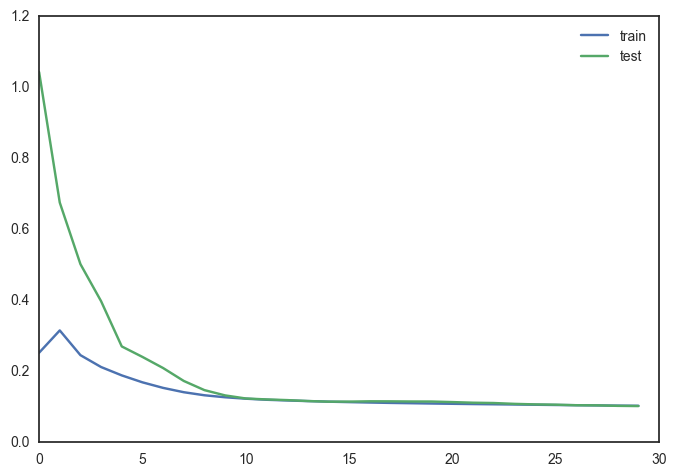

In [215]:
# design network
model = Sequential()
model.add(Masking(mask_value=-1, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(5))
model.add(Dense(train_X.shape[1]))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=3, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Make a prediction and evaluate the performance

In [216]:
# make a prediction
yhat = model.predict(test_X)

# make yhat dimension match test_X
yhat = numpy.expand_dims(yhat,axis=2)

# invert scaling for forecast
inv_yhat = numpy.concatenate((test_X[:,:,:-1],yhat), axis=2)
for i in range(inv_yhat.shape[1]):
    inv_yhat[:,i,:] = scaler.inverse_transform(inv_yhat[:,i,:])
inv_yhat = inv_yhat[:,:,-1]

# invert scaling for actual

# make y dimension match test_X
test_y = numpy.expand_dims(test_y,axis=2)

#test_y = test_y.reshape((len(test_y), 1))
inv_y = numpy.concatenate((test_X[:, :, :-1],test_y), axis=2)
for i in range(inv_y.shape[1]):
    inv_y[:,i,:] = scaler.inverse_transform(inv_y[:,i,:])
inv_y = inv_y[:,:,-1]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 17.213


Let's see how we did for these fellas in particular.

for i in range(inv_yhat.shape[0]):
    print('(predicted,actual) = ( %s , %s )' % (int(inv_yhat[i,0]),int(inv_y[i,0])))

In [217]:
# Recall, 2015-2016 Forecast Mags scored as low as 16.002, and as high as 17.277.
# Previous season's production (normalized to 82 games) scores 17.319!
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 15.814


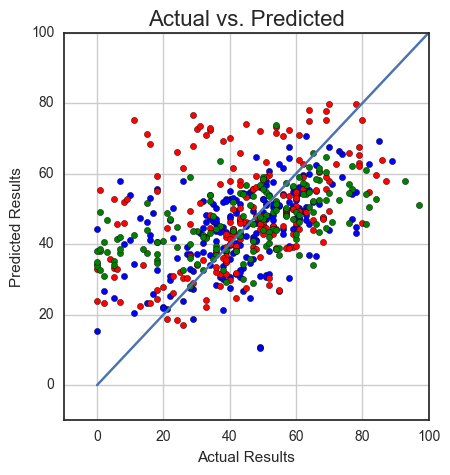

In [218]:
fig1 = pyplot.figure(figsize=(16,5))
az = fig1.add_subplot(1,3,3)
az.scatter(inv_y[:,0],inv_yhat[:,0],c="b")
az.scatter(inv_y[:,1],inv_yhat[:,1],c="r")
az.scatter(inv_y[:,2],inv_yhat[:,2],c="g")
az.plot([0,50,120],[0,50,120])
pyplot.ylim(-10,100)
pyplot.xlim(-10,100)
pyplot.xlabel('Actual Results')
pyplot.ylabel('Predicted Results')
pyplot.title('Actual vs. Predicted', fontsize=16)
pyplot.grid(True)

I used the code snipped below to capture results from a number of model+prediction runs so I could plot several version of results at once.

In [219]:
#test55=[inv_y[:,0],inv_yhat[:,0]]

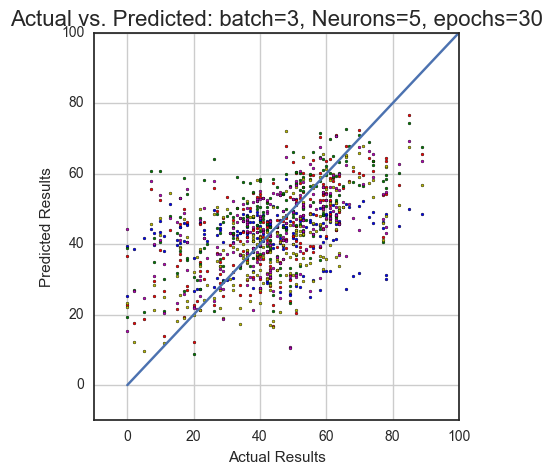

In [221]:


fig1 = pyplot.figure(figsize=(16,5))
az = fig1.add_subplot(1,3,2)
az.scatter(test51[0],test51[1],c="b",s=4)
az.scatter(test52[0],test52[1],c="r",s=4)
az.scatter(test53[0],test53[1],c="g",s=4)
az.scatter(test54[0],test54[1],c="y",s=4)
az.scatter(test55[0],test55[1],c="m",s=4)
#az.scatter(testaverage[0],testaverage[1],c="c")
az.plot([0,50,120],[0,50,120])
pyplot.ylim(-10,100)
pyplot.xlim(-10,100)
pyplot.xlabel('Actual Results')
pyplot.ylabel('Predicted Results')
pyplot.title('Actual vs. Predicted: batch=3, Neurons=5, epochs=30', fontsize=16)
pyplot.grid(True)
